Yea we train in Jupyter now, deal with it.

In [1]:
import numpy as np

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from torch.utils.data import WeightedRandomSampler

from assembly_extract import OPS_LENGTH

import random

import networkx as nx
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GATv2Conv

c:\Users\IEUser\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
latent_dim = 64

lr = 1e-4

In [3]:
def visualize_graph(G, color = None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos = nx.spring_layout(G, seed = 42), with_labels = False,
                     node_size = 32, node_color = color, cmap = "Set2", alpha = 0.5)
    plt.show()


def visualize_embedding(h, color = None, epoch = None, loss = None):
    plt.figure(figsize = (7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s = 140, cmap = "Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize = 16)
    plt.show()

In [40]:
dataset = torch.load('data/dataset16N.pt')
random.shuffle(dataset)

print(f"Amount of items: {len(dataset)}")

bn = 0
rs = 0

for d in dataset:
    if d.y.item() == 1:
        rs += 1
    elif d.y.item() == 0:
        bn += 1

print(f"Amount of ransomware: {rs}")
print(f"Amount of benign: {bn}")

data_len = len(dataset)
train_amo = round(data_len * 0.8)

train_data = dataset[:train_amo]
test_data = dataset[train_amo:]

bn = 0
rs = 0

for d in train_data:
    if d.y.item() == 1:
        rs += 1
    elif d.y.item() == 0:
        bn += 1
        
class_weight = [1 / bn, 1 / rs]
sample_weight = torch.from_numpy(np.array([class_weight[data.y] for data in train_data]))
sampler = WeightedRandomSampler(sample_weight.type(torch.DoubleTensor), len(sample_weight))

train_loader = DataLoader(train_data, batch_size=64, sampler = sampler)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Amount of items: 6980
Amount of ransomware: 5001
Amount of benign: 1979


In [70]:
from torch_geometric.utils import to_networkx

print(f'Number of graphs: {len(dataset)}')

nodes = []
for d in dataset:
    nodes.append(d.x.shape[0])
    
nodes = np.array(nodes)
nodes_avg = np.mean(nodes)
nodes_sd  = np.std(nodes)

print(f"Avg nodes count: {nodes_avg:.2f}")
print(f"Avg nodes sd: {nodes_sd:.2f}")

Number of graphs: 6980
[ 1879 10160    17 ...  5663  2061  2061]
Avg nodes count: 11008.85
Avg nodes sd: 765174062.91


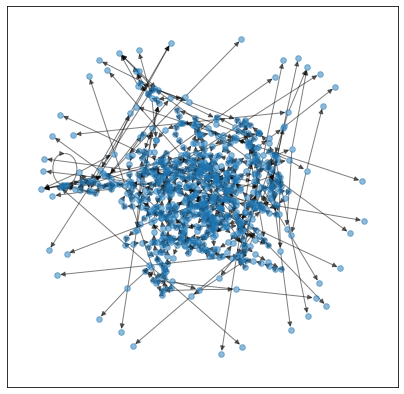

In [57]:
#G = to_networkx(data[9], to_undirected = False)
#visualize_graph(G)

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, embed_dim = 16):
        super(GCN, self).__init__()
        
        #self.embed = nn.Embedding(OPS_LENGTH, embed_dim)
        self.conv1 = GCNConv(OPS_LENGTH, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.lin = nn.Linear(hidden_channels, 2)
        self.lin = nn.Sequential(
            nn.Linear(hidden_channels, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 2)
        ) 

    def forward(self, x, edge_index, batch):
        #print(f"input shape : {x.shape}")
        #print(f"edge shape : {edge_index.shape}")
        #x = self.embed(x)
        
        #print(f"embeded shape : {x.shape}")
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [4]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(OPS_LENGTH, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels)
        self.conv3 = GATv2Conv(hidden_channels, hidden_channels)
        self.lin = nn.Sequential(
            nn.Linear(hidden_channels, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 2)
        ) 

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [5]:
from tqdm import tqdm
import matplotlib.pyplot as plt

EPOCH = 10
latent_dim = 16
embed_dim = 1260

#model = GCN(hidden_channels = latent_dim, embed_dim = embed_dim)
model = GAT(hidden_channels = latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

print(model)

GAT(
  (conv1): GATv2Conv(16, 16, heads=1)
  (conv2): GATv2Conv(16, 16, heads=1)
  (conv3): GATv2Conv(16, 16, heads=1)
  (lin): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


100%|██████████| 88/88 [11:08<00:00,  7.59s/it]


Epoch: 001, Test F1: 0.5835, Test acc: 0.7944


100%|██████████| 88/88 [10:46<00:00,  7.35s/it]


Epoch: 002, Test F1: 0.6246, Test acc: 0.7572


100%|██████████| 88/88 [10:19<00:00,  7.04s/it]


Epoch: 003, Test F1: 0.5293, Test acc: 0.5910


100%|██████████| 88/88 [10:47<00:00,  7.36s/it]


Epoch: 004, Test F1: 0.6556, Test acc: 0.8066


100%|██████████| 88/88 [10:32<00:00,  7.19s/it]


Epoch: 005, Test F1: 0.6543, Test acc: 0.8001


100%|██████████| 88/88 [10:12<00:00,  6.96s/it]


Epoch: 006, Test F1: 0.6658, Test acc: 0.8116


100%|██████████| 88/88 [10:26<00:00,  7.12s/it]


Epoch: 007, Test F1: 0.6539, Test acc: 0.7930


100%|██████████| 88/88 [10:22<00:00,  7.08s/it]


Epoch: 008, Test F1: 0.6683, Test acc: 0.8087


100%|██████████| 88/88 [10:26<00:00,  7.12s/it]


Epoch: 009, Test F1: 0.6675, Test acc: 0.8073


100%|██████████| 88/88 [10:26<00:00,  7.12s/it]


Epoch: 010, Test F1: 0.6786, Test acc: 0.8195


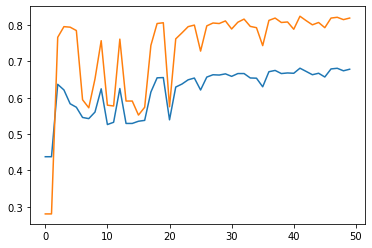

In [9]:
from torchmetrics import ConfusionMatrix

f1 = []
acc = []
best = 0

def train():
    model.train()
    test_loop = 0

    for data in tqdm(train_loader):
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad()  
        
        test_loop += 1
        if test_loop > 20:
            test_loop = 0
            test()

def test():
    model.eval()

    Apred = []
    Atarg = []
    
    for data in test_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim = 1)  
        
        Apred.append(pred)
        Atarg.append(data.y)
        
    Apred = torch.concat(Apred)
    Atarg = torch.concat(Atarg)
    
    confmat = ConfusionMatrix(num_classes = 2)
    conf = confmat(Apred, Atarg).numpy()
    
    test_f1 = conf[0][0] / (conf[0][0] + 1/2 * (conf[0][1] + conf[1][0]))
    test_acc = (conf[0][0] + conf[1][1]) / (conf[0][0] + conf[0][1] + conf[1][0] + conf[1][1])
    
    f1.append(test_f1)
    acc.append(test_acc)
     
    return test_f1, test_acc

#WEIGHT_PATH = "data/weightGAT.pt"
for e in range(EPOCH):
    train()
    test_f1, test_acc = test()
    
    if test_f1 > best:
        best = test_f1
        #torch.save(model.state_dict(), WEIGHT_PATH)
    
    print(f'Epoch: {e+1:03d}, Test F1: {test_f1:.4f}, Test acc: {test_acc:.4f}')

plt.plot(f1)
plt.plot(acc)
plt.show()

## Load & Interence

In [6]:
WEIGHT_PATH = "data/weightGAT.pt"

inference_model = GAT(hidden_channels = latent_dim)
inference_model.load_state_dict(torch.load(WEIGHT_PATH))
inference_model.eval()
print(inference_model)

GAT(
  (conv1): GATv2Conv(16, 16, heads=1)
  (conv2): GATv2Conv(16, 16, heads=1)
  (conv3): GATv2Conv(16, 16, heads=1)
  (lin): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [7]:
from dismgrp import dismgrp

def isRansom(path):
    try:
        data = dismgrp(path)
    except Exception as e:
        raise e
    
    res = inference_model(data.x, data.edge_index, data.batch)[0]
    
    pre = torch.argmax(res).item()
    prob = res[pre].item() * 100
    return pre, prob

In [12]:
import os

p = "C:/Users/IEUser/Desktop/Test PE/ransom/"
i = 6000
for f in os.listdir(p)[i : i + 1000]:
    pth = p + f
    try:
        pre, prob = isRansom(pth)
        res = "Ransom" if pre == 1 else "Safe"
        print(f"File: {f}: {prob:.0f}% {res}")
    except Exception as e:
        print(f"File: {f}: Error, " + str(e))

File: VirusShare_22e220247fc36dcd6aad51f825e59010: 81% Safe
File: VirusShare_22e27b275081902fcbe4c9689aa3d910: Error, Error decompiling file: Disasembler return none
File: VirusShare_22e37fd19808c24d775cb6b9b52d1620: 81% Safe
File: VirusShare_22e6a1618da3210408f27bd3dfd3fb60: 81% Safe
File: VirusShare_22e81f9fbac3142f6d97d62b75b76ed7: Error, index 0 is out of bounds for dimension 0 with size 0
File: VirusShare_22eba7055450104493c13837d93058a0: Error, index 0 is out of bounds for dimension 0 with size 0
File: VirusShare_22ebc2330e0f9f27da3c45fb85332030: 78% Safe
File: VirusShare_22ef9eecc7052389e5b2f968cc35b450: Error, index 0 is out of bounds for dimension 0 with size 0
File: VirusShare_22efa8cc1cc4d6499e5453c8bd0d69c6: 81% Safe
File: VirusShare_22f0d590d8d6f372d027806afed3dd2f: 81% Safe
File: VirusShare_22f2527444c8025bdd8605ebfbd659a4: 78% Safe
File: VirusShare_22f2ca052440097328da09628f485d93: 52% Ransom
File: VirusShare_22f4c1b051ad1786bd5fbbe9bb53d630: Error, Error decompiling fil

KeyboardInterrupt: 

In [35]:
pre, prob = isRansom("D:/Work/SIIT/4th year/1 - 2022/CSS453 Cyber crime/project/pe/benign/7z.exe")
res = "Ransom" if pre == 1 else "Safe"
print(f"{prob:.0f}% {res}")

81% Safe
